In [1]:
!nvidia-smi

Tue Mar  2 17:43:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import tqdm

In [172]:
class PCB_Env:

    def __init__(self, size_h, size_w):
        self.field = None
        self.agent_position = None
        self.target_position = None
        self.size_h = size_h
        self.size_w = size_w
        self.action_dict = {'right': 0, 'left': 1, 'up': 2, 'down': 3}
        self.action_space = {0: self.step_right, 1: self.step_left,
                             2: self.step_up, 3: self.step_down}
        self.standing_still = 0

    def check(self, x, y):
        grid_check = self.size_w > x >= 0 and self.size_h > y >= 0
        cross_check = True
        if grid_check:
          cross_check = self.field[y][x] != 1
        return grid_check and cross_check

    def step_up(self):
        x, y = self.agent_position
        if self.check(x, y + 1):
            self.field[y][x] = 1
            self.field[y+1][x] = 2
            self.agent_position = (x, y+1)
            return True
        else:
            return False

    def step_down(self):
        x, y = self.agent_position
        if self.check(x, y - 1):
            self.field[y][x] = 1
            self.field[y-1][x] = 2
            self.agent_position = (x, y-1)
            return True
        else:
            return False

    def step_left(self):
        x, y = self.agent_position
        if self.check(x-1, y):
            self.field[y][x] = 1
            self.field[y][x-1] = 2
            self.agent_position = (x-1, y)
            return True
        else:
            return False

    def step_right(self):
        x, y = self.agent_position
        if self.check(x+1, y):
            self.field[y][x] = 1
            self.field[y][x+1] = 2
            self.agent_position = (x+1, y)
            return True
        else:
            return False

    def calculate_reward(self, x1, y1, x2, y2):
        dst1 = math.hypot(self.target_position[0] - x1, 
                          self.target_position[1] - y1)
        dst2 = math.hypot(self.target_position[0] - x2, 
                          self.target_position[1] - y2)
        return int(dst1 > dst2) * 2 - 1


    def step(self, direction, n):
        assert direction in self.action_space
        start_field = self.field.copy()
        x1, y1 = self.agent_position
        step_function = self.action_space[direction]
        if n == 0:
            reward = -10
            self.standing_still += 1
            self.field = start_field
            return self.field, reward, False, self.standing_still
        for i in range(n):
          result = step_function()
          if not result:
            reward = -10
            self.standing_still += 1
            self.field = start_field
            return self.field, reward, False, self.standing_still
        x2, y2 = self.agent_position
        done = self.agent_position == self.target_position
        reward = self.calculate_reward(x1, y1, x2, y2)
        self.standing_still = 0
        if done:
            reward = 20
        return self.field, reward, done, self.standing_still

    def reset(self, start_x, start_y, end_x, end_y):
        self.field = np.zeros((self.size_h, self.size_w))
        self.field[start_y][start_x] = 2
        self.field[end_y][end_x] = 2
        self.agent_position = (start_x, start_y)
        self.target_position = (end_x, end_y)
        self.standing_still = 0
        return self.field

    def render(self):
        plt.imshow(self.field)
        plt.draw()
        plt.pause(0.0001)

In [238]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [288]:
class Critic(nn.Module):

    def __init__(self, h, w):
        super(Critic, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fc1 = nn.Linear(h * w + 2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x, a):
        x = x.to(self.device, dtype=torch.float)
        a = a.to(self.device, dtype=torch.float)
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))
        print(x.shape, a.shape)
        x = torch.cat((x, a), 1).to(self.device, dtype=torch.float)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Actor(nn.Module):

    def __init__(self, h, w):
        super(Actor, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fc1 = nn.Linear(h * w, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 4)
        self.fc4 = nn.Linear(100, 1)

    def forward(self, x):
        x = x.to(self.device, dtype=torch.float)
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        dir = F.softmax(self.fc3(x))
        dist = self.fc4(x)
        return torch.cat((dir, dist), 1).to(self.device, dtype=torch.float)

In [276]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [292]:
BATCH_SIZE = 128
GAMMA = 0.8
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100
TARGET_UPDATE = 50
SIZE_H, SIZE_W = 50, 50


ENV = PCB_Env(size_h=SIZE_H, size_w=SIZE_W)

# target_actor, policy_actor, target_critic, policy_critic

def select_action(state, steps_done, policy_actor):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            prediction = policy_actor(state)
            dir, dist = prediction[:,:3], prediction[:,-1]
            dir = torch.tensor([dir.argmax()], device=device)
            dist = torch.tensor([int(dist)], device=device)
            return dir, dist
    else:
        dir = torch.tensor([random.randrange(4)], device=device)
        dist = torch.tensor([int(random.uniform(0, SIZE_H / 2))], device=device)
        return dir, dist


In [323]:
def optimize_critic(target_actor, policy_actor, 
                    target_critic, policy_critic, 
                    optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, 
                                  dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_critic(state_batch, action_batch)  #.gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    prediction = target_actor(non_final_next_states)
    dir, dist = prediction[:,:3], prediction[:,-1]
    dir = dir.argmax(1)
    print(dir.shape)
    next_state_values[non_final_mask] = target_critic(non_final_next_states, 
                                                      torch.cat((dir, dist)).expand((1, 2))).detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values.float(), 
                            expected_state_action_values.unsqueeze(1).float())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_critic.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()


def optimize_actor(target_actor, policy_actor, 
                   target_critic, policy_critic, 
                   optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    actions_pred = policy_actor(state_batch)
    actor_loss = -policy_critic(state_batch, actions_pred).mean()

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def update_target(policy_net, target_net):
    upd_dict = dict()
    policy_state_dict = policy_net.state_dict()
    target_state_dict = target_net.state_dict()
    for key, value in policy_state_dict.items():
        upd_dict[key] = value * (1 - 1 / TARGET_UPDATE) + target_state_dict[key] / TARGET_UPDATE
    target_net.load_state_dict(upd_dict)
    return target_net

In [324]:
policy_critic = Critic(SIZE_H, SIZE_W).to(device)
target_critic = Critic(SIZE_H, SIZE_W).to(device)
policy_actor = Actor(SIZE_H, SIZE_W).to(device)
target_actor = Actor(SIZE_H, SIZE_W).to(device)

target_critic.load_state_dict(policy_critic.state_dict())
target_critic.eval()
target_actor.load_state_dict(policy_actor.state_dict())
target_actor.eval()

optimizer_critic = optim.RMSprop(policy_critic.parameters())
optimizer_actor = optim.RMSprop(policy_actor.parameters())
memory = ReplayMemory(100000)
steps_done = 0

result = list()
losses_actor = list()
losses_critic = list()
heatmaps = list()
heatmap = np.zeros((SIZE_H, SIZE_W))

num_episodes = 1000
for i_episode in tqdm.notebook.tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = ENV.reset(5, 5, 40, 40) / 3
    state = torch.from_numpy(state).unsqueeze(0).to(device)
    total_reward = 0
    total_loss_actor = 0
    total_loss_critic = 0
    for t in count():
        # Select and perform an action
        action_dir, action_dst = select_action(state, steps_done, policy_actor)
        steps_done += 1
        next_state, reward, done, ss = ENV.step(action_dir.item(), action_dst.item())
        next_state = torch.from_numpy(next_state / 3).unsqueeze(0).to(device)
        total_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if done:
            next_state = None

        memory.push(state, torch.cat((action_dir, action_dst)).expand((1, 2)), 
                    next_state, reward)
        state = next_state

        if done or ss > 3:
            loss_critic = optimize_critic(target_actor, policy_actor, 
                                          target_critic, policy_critic, 
                                          optimizer_critic)
            loss_actor = optimize_actor(target_actor, policy_actor, 
                                        target_critic, policy_critic, 
                                        optimizer_actor)
            if loss_actor:
              total_loss_actor += loss_actor
              total_loss_critic += loss_critic
            result.append(total_reward)
            losses_actor.append(total_loss_actor)
            losses_critic.append(total_loss_critic)
            heatmap += ENV.field
            if i_episode % 500 == 0 and i_episode > 0:
              heatmaps.append(heatmap)
              heatmap = np.zeros((SIZE_H, SIZE_W))
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_actor = update_target(policy_actor, target_actor)
        target_critic = update_target(policy_critic, target_critic)


_ = plt.plot(result)
plt.grid(True)
plt.show()

_ = plt.plot([np.mean(result[n:n+50]) for n in range(0, len(result), 50)])
plt.grid(True)
plt.show()

_ = plt.plot(losses_actor)
plt.grid(True)
plt.show()

_ = plt.plot(losses_critic)
plt.grid(True)
plt.show()

# _ = plt.plot([np.mean(losses[n:n+20]) for n in range(0, len(losses), 20)])
# plt.grid(True)
# plt.show()

fig, axs = plt.subplots(len(heatmaps) // 5 + 1, 5, figsize=(15, 15))
axs = axs.flatten()
for n in range(len(heatmaps)):
  _ = axs[n].matshow(heatmaps[n])

torch.Size([128, 2500]) torch.Size([128, 2])
torch.Size([128])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: ignored

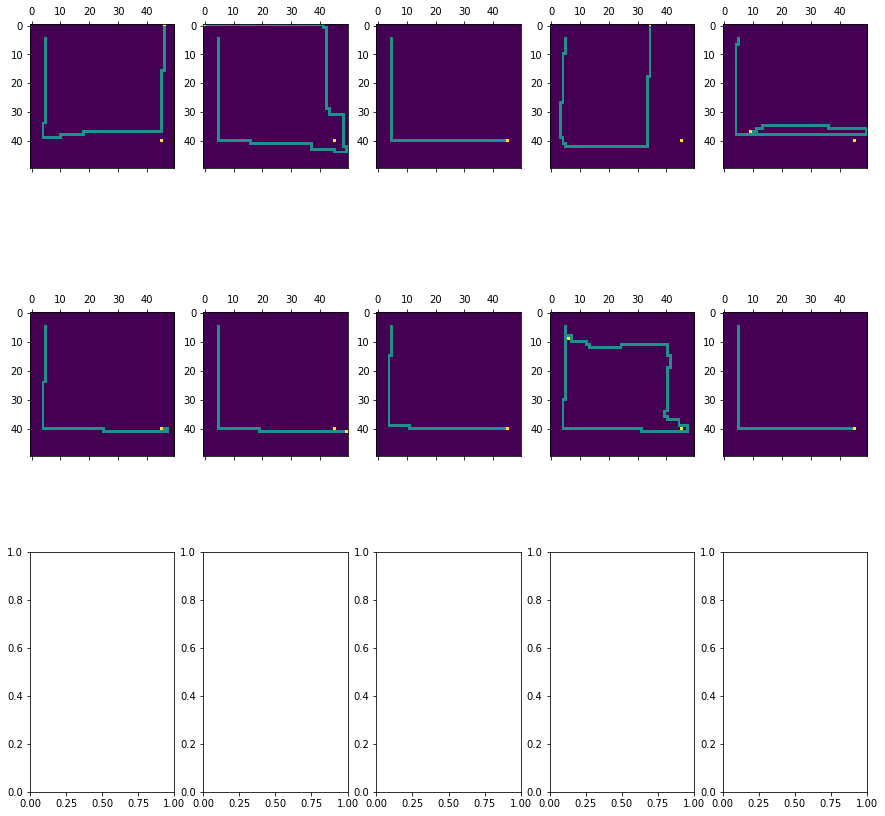

In [19]:
num_episodes = 10
heatmaps = list()
heatmap = np.zeros((SIZE_H, SIZE_W))
for i_episode in tqdm.notebook.tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = ENV.reset(5, 5, 45, 40) / 3
    state = torch.from_numpy(state).unsqueeze(0).to(device)
    total_reward = 0
    total_loss = 0
    for t in count():
        # Select and perform an action
        # action = policy_net(state).max(1)[1].view(1, 1)
        action = select_action(state)
        next_state, reward, done, ss, position = ENV.step(action.item())
        position = position[0] / SIZE_H, position[1] / SIZE_W
        next_state = torch.from_numpy(next_state / 3).unsqueeze(0).to(device)
        total_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        #print(reward)
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        #loss = optimize_model()
        #if loss:
            #total_loss += loss
        if done or ss > 10:
            result.append(total_reward)
            heatmap += ENV.field
            if i_episode % 1 == 0: #and i_episode > 0:
              heatmaps.append(heatmap)
              heatmap = np.zeros((SIZE_H, SIZE_W))
            break

fig, axs = plt.subplots(len(heatmaps) // 5 + 1, 5, figsize=(15, 15))
axs = axs.flatten()
for n in range(len(heatmaps)):
  _ = axs[n].matshow(heatmaps[n])